    conf  precision    recall     model        f1
0   0.05   0.920345  0.925478  baseline  0.922904
1   0.10   0.920345  0.925478  baseline  0.922904
2   0.15   0.920345  0.925478  baseline  0.922904
3   0.20   0.920345  0.925478  baseline  0.922904
4   0.25   0.920345  0.925478  baseline  0.922904
5   0.30   0.920345  0.925478  baseline  0.922904
6   0.35   0.919157  0.926823  baseline  0.922974
7   0.40   0.925615  0.920635  baseline  0.923118
8   0.45   0.931662  0.909605  baseline  0.920501
9   0.50   0.937570  0.900995  baseline  0.918919
10  0.55   0.941110  0.889965  baseline  0.914823
11  0.60   0.946740  0.875168  baseline  0.909548
12  0.65   0.949732  0.859026  baseline  0.902105
13  0.70   0.954601  0.837234  baseline  0.892074
14  0.75   0.959459  0.802260  baseline  0.873846
15  0.80   0.973410  0.728814  baseline  0.833538
16  0.85   0.975069  0.473500  baseline  0.637450
17  0.90   0.980198  0.186441  baseline  0.313291
18  0.95   1.000000  0.002152  baseline  0.004295


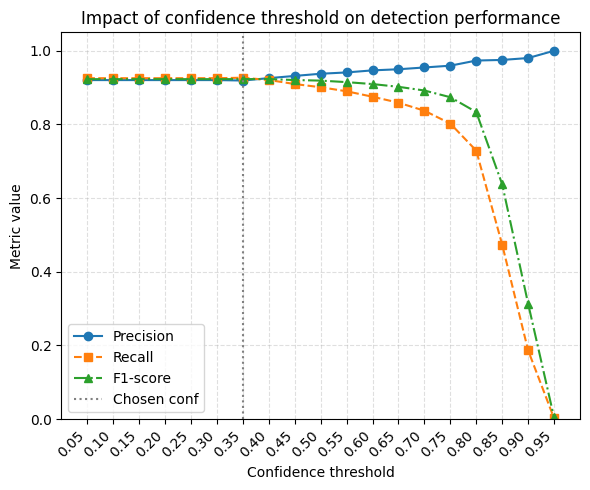


Résumé écrit dans : analysis_conf_global/summary_auc_pr_operating_point.csv


In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
analyze_conf_sweep.py

Analyse un sweep de seuil de confiance (sorti de sweep_conf_thresholds.py) pour :
  - calculer l'AUC-PR (Precision-Recall) par modèle,
  - choisir un seuil de fonctionnement (conf) qui maximise F1,
  - générer des figures :
        * Precision-Recall curve + operating point
        * Precision/Recall/F1 vs confidence
  - produire un CSV résumé.

Entrée attendue : un CSV avec au moins les colonnes
  model, conf, precision, recall, f1

Exemple d'utilisation :
-----------------------
python analyze_conf_sweep.py \
    --csv conf_sweep_global.csv \
    --out-dir analysis_conf_global
"""

import argparse
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc



def main():

    out_dir = Path("analysis_conf_global")
    out_dir.mkdir(parents=True, exist_ok=True)

    df = pd.read_csv("pr_sweep.csv")

    required_cols = {"model", "conf", "precision", "recall"}
    if not required_cols.issubset(df.columns):
        raise ValueError(
            f"Le CSV doit contenir au moins les colonnes : {required_cols} "
            f"(colonnes présentes : {list(df.columns)})"
        )

    # Si f1 n'existe pas, on le calcule
    if "f1" not in df.columns:
        df["f1"] = 2 * df["precision"] * df["recall"] / (df["precision"] + df["recall"])
        df["f1"] = df["f1"].fillna(0.0)

    summary_rows = []

    for model_name, g in df.groupby("model"):
        model_name = "Mix-Strong" if model_name == "baseline" else model_name
        g = g.dropna(subset=["precision", "recall"]).copy()

        if g.empty:
            print(f"[WARN] Pas de données valides pour le modèle {model_name}")
            continue

        # --- AUC-PR ---
        # On trie par recall croissant pour intégrer correctement
        g_pr = g.sort_values("recall")
        auc_pr = auc(g_pr["recall"], g_pr["precision"])

        # --- Point de fonctionnement : F1 max ---
        best_idx = g["f1"].idxmax()
        best = g.loc[best_idx]
        print(g)

        chosen_conf = float(0.35)
        chosen_prec = float(best["precision"])
        chosen_rec = float(best["recall"])
        chosen_f1 = float(best["f1"])

        print(
            f"\n=== Modèle: {model_name} ===\n"
            f"AUC-PR        : {auc_pr:.4f}\n"
            f"Seuil choisi  : conf={chosen_conf:.3f} (max F1)\n"
            f"Precision     : {chosen_prec:.3f}\n"
            f"Recall        : {chosen_rec:.3f}\n"
            f"F1            : {chosen_f1:.3f}"
        )

        summary_rows.append(
            {
                "model": model_name,
                "auc_pr": auc_pr,
                "chosen_conf": chosen_conf,
                "precision_at_conf": chosen_prec,
                "recall_at_conf": chosen_rec,
                "f1_at_conf": chosen_f1,
            }
        )

        # --- Figure 1 : Precision-Recall curve + operating point ---
        plt.figure(figsize=(6, 5))
        plt.plot(
            g_pr["recall"],
            g_pr["precision"],
            marker="o",
            linestyle="-",
            label="PR curve",
        )
        plt.scatter(
            [chosen_rec],
            [chosen_prec],
            marker="x",
            s=80,
            linewidths=2,
            label=f"Operating point (conf={chosen_conf:.2f})",
        )
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision-Recall curve – {model_name}\nAUC-PR = {auc_pr:.3f}")
        plt.xlim(0.0, 1.0)
        plt.ylim(0.0, 1.05)
        plt.grid(True, linestyle="--", alpha=0.4)
        plt.legend()
        plt.tight_layout()
        plt.savefig(out_dir / f"{model_name}_pr_curve.png", dpi=300)
        plt.close()

        # --- Figure 2 : Precision / Recall / F1 vs confidence ---
        g_conf = g.sort_values("conf")

        plt.figure(figsize=(6, 5))
        plt.plot(
            g_conf["conf"],
            g_conf["precision"],
            marker="o",
            linestyle="-",
            label="Precision",
        )
        plt.plot(
            g_conf["conf"],
            g_conf["recall"],
            marker="s",
            linestyle="--",
            label="Recall",
        )
        plt.plot(
            g_conf["conf"],
            g_conf["f1"],
            marker="^",
            linestyle="-.",
            label="F1-score",
        )
        # point vertical sur le seuil choisi
        plt.axvline(chosen_conf, color="grey", linestyle=":", label="Chosen conf")
        plt.xlabel("Confidence threshold")
        plt.ylabel("Metric value")
        plt.title(f"Impact of confidence threshold on detection performance")
        conf_values = g_conf["conf"].values # ou ta liste de seuils
        plt.xticks(
            conf_values,
            [f"{c:.2f}" for c in conf_values],
            rotation=45,
            ha="right"
        )
        plt.xlim(0, g_conf["conf"].max()+0.05)
        plt.ylim(0.0, 1.05)
        plt.grid(True, linestyle="--", alpha=0.4)
        plt.legend()
        plt.tight_layout()
        plt.savefig(out_dir / f"{model_name}_metrics_vs_conf.pdf", dpi=300)
        plt.show()
        plt.close()

    # --- CSV résumé ---
    if summary_rows:
        df_summary = pd.DataFrame(summary_rows)
        df_summary.to_csv(out_dir / "summary_auc_pr_operating_point.csv", index=False)
        print(f"\nRésumé écrit dans : {out_dir/'summary_auc_pr_operating_point.csv'}")
    else:
        print("\n[WARN] Aucun modèle n'a pu être résumé.")


if __name__ == "__main__":
    main()
